In [4]:
import networkx as nx
import dwave_networkx as dnx
import minorminer
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random


In [ ]:
# --- set the size you actually want ---
N = 200   # number of nodes PER layer (total logical nodes = 2*N)

# create node labels (you can choose any hashable labels)
L1_nodes = [f"L1_{i}" for i in range(N)]
L2_nodes = [f"L2_{i}" for i in range(N)]

G_logical = nx.Graph()
G_logical.add_nodes_from(L1_nodes, bipartite=0)
G_logical.add_nodes_from(L2_nodes, bipartite=1)

# Alternating connectivity (interpretation of your bullets):
# - even-indexed L1 nodes (i%2==0) connect to odd-indexed L2 nodes (j%2==1)
# - odd-indexed L2 nodes (i%2==1) connect to even-indexed L1 nodes (j%2==0)
for i in range(N):
    if i % 2 == 0:
        l1 = L1_nodes[i]
        for j in range(N):
            if j % 2 == 1:
                l2 = L2_nodes[j]
                G_logical.add_edge(l1, l2)
    if i % 2 == 1:
        l2 = L2_nodes[i]
        for j in range(N):
            if j % 2 == 0:
                l1 = L1_nodes[j]
                G_logical.add_edge(l2, l1)

print(f"Logical graph: {G_logical.number_of_nodes()} nodes, {G_logical.number_of_edges()} edges")

# --- get target (hardware) graph ---
# Option A: prototype locally with a perfect Zephyr of size m
G_target = dnx.zephyr_graph(16)   # choose m that gives enough qubits (increase m if needed)
print(f"Target zephyr_graph (m=16): {G_target.number_of_nodes()} nodes, {G_target.number_of_edges()} edges")

# Option B: (preferred if you will run on a real sampler)
# sampler = DWaveSampler()                 # uncomment if you have credentials
# G_target = sampler.to_networkx_graph()   # real hardware topology (with defects accounted for)

# --- try minorminer ---
params = dict(tries=30, timeout=60, threads=4, chainlength_patience=20, verbose=2)
embedding = minorminer.find_embedding(G_logical, G_target, **params)

if embedding:
    chain_lengths = [len(chain) for chain in embedding.values()]
    print("Embedding found")
    print(f"  max chain length: {max(chain_lengths)}")
    print(f"  avg chain length: {sum(chain_lengths)/len(chain_lengths):.2f}")
else:
    print("No embedding found (embedding is empty). Try reducing density or increasing tries/target size.")


Logical graph: 400 nodes, 10000 edges
Target zephyr_graph (m=16): 8448 nodes, 81640 edges


TypeError: find_embedding() got an unexpected keyword argument 'chainlength'

Building logical graph with N=100 and K_NEIGHBORS=4...
Logical graph (N=100, K=4): 200 nodes, 400 edges
Graph is connected: True
Building logical graph with N=100 and K_NEIGHBORS=4...
Logical graph for visualization (N=100, K=4): 200 nodes, 400 edges
Graph is connected: True


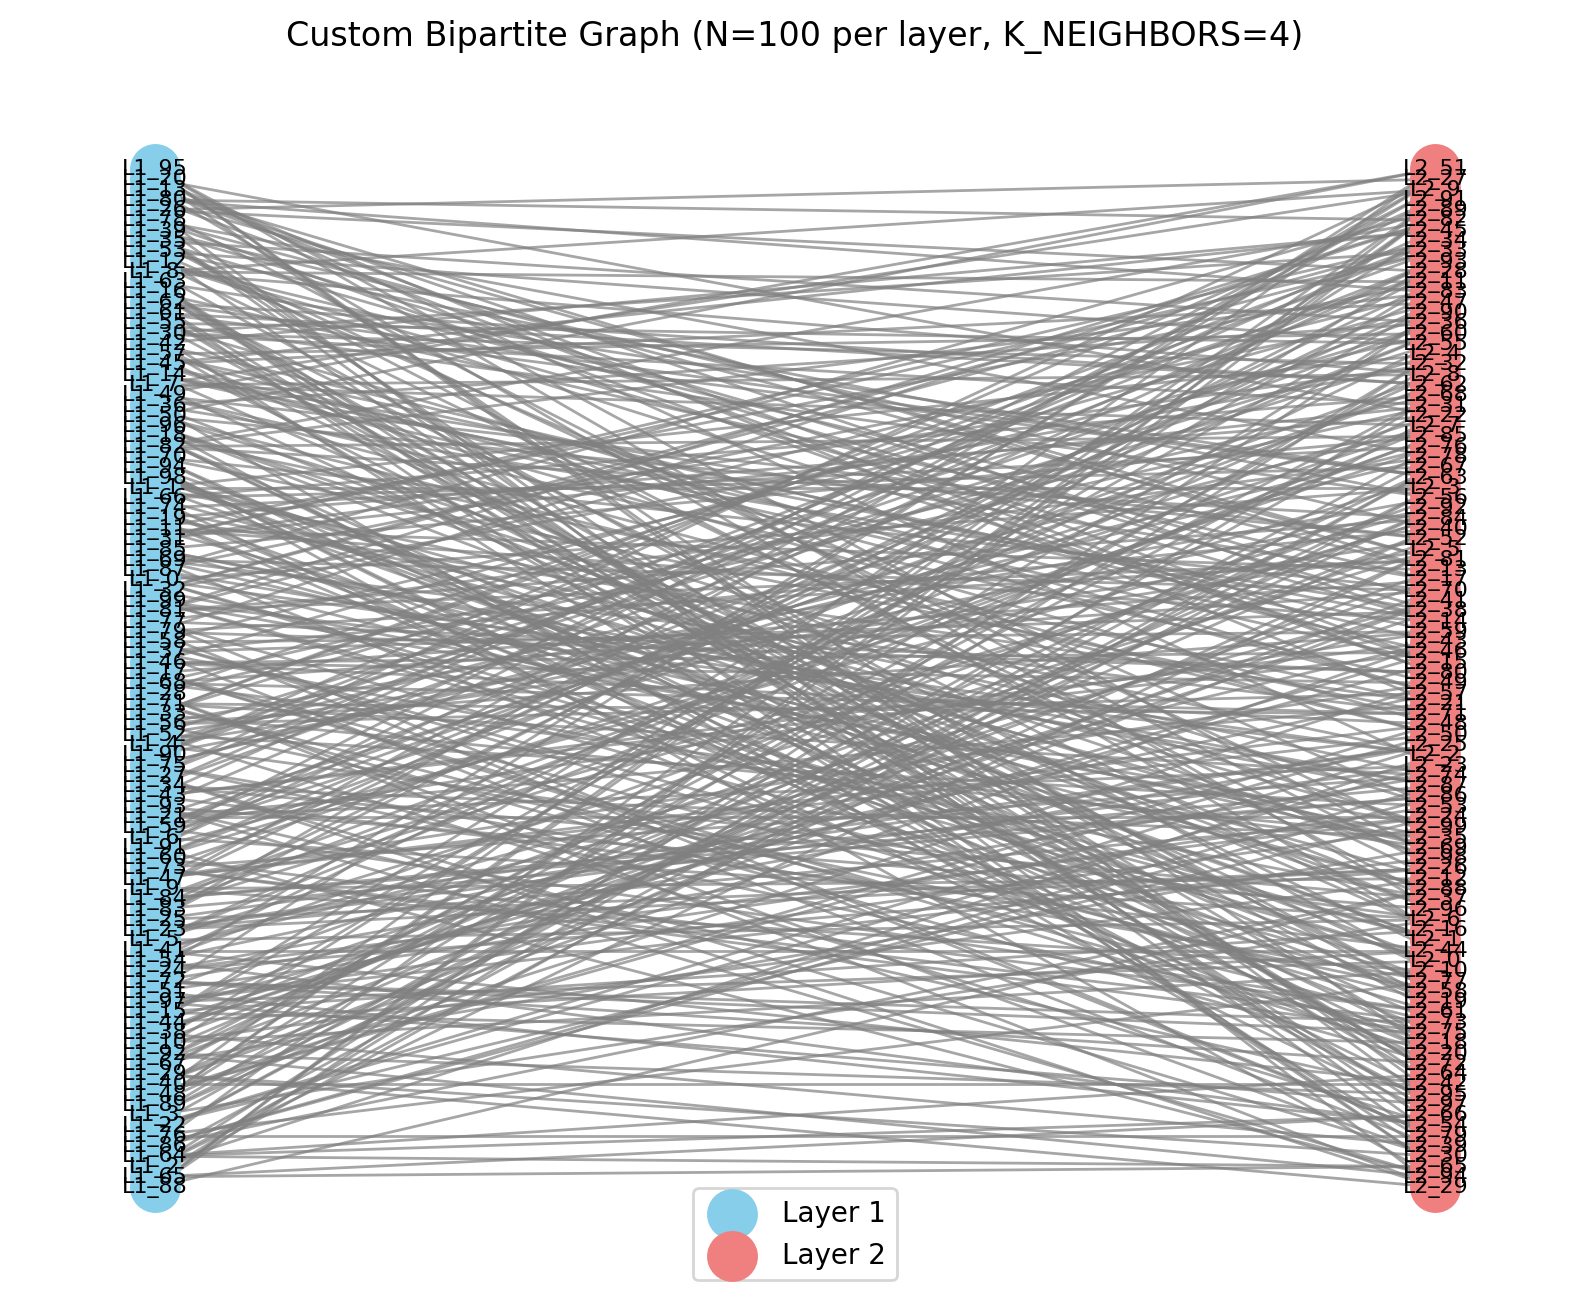

In [14]:
import networkx as nx
import dwave_networkx as dnx
import minorminer
# from dwave.system import DWaveSampler # Uncomment for real hardware

# --- set the size you actually want ---
N = 100     # number of nodes PER layer (total logical nodes = 2*N)
K_NEIGHBORS = 4  # The number of neighbors for each L1 node.
               # Must be >= 2 to ensure a connected graph.

def create_logical_graph(n_nodes, k_neighbors):
    """
    Creates a bipartite graph with n_nodes in each layer (L1, L2).
    
    Connects each node L1[i] to k_neighbors nodes in L2, starting
    from L2[i] and wrapping around the layer using modulo.
    
    This creates a single, connected graph (for k_neighbors >= 2) 
    with a total of (n_nodes * k_neighbors) edges.
    """
    L1_nodes = [f"L1_{i}" for i in range(n_nodes)]
    L2_nodes = [f"L2_{i}" for i in range(n_nodes)]

    G_logical = nx.Graph()
    G_logical.add_nodes_from(L1_nodes, bipartite=0)
    G_logical.add_nodes_from(L2_nodes, bipartite=1)

    print(f"Building logical graph with N={n_nodes} and K_NEIGHBORS={k_neighbors}...")
    
    if k_neighbors > n_nodes:
        print(f"Warning: k_neighbors ({k_neighbors}) is > N ({n_nodes}). Clamping to N.")
        k_neighbors = n_nodes
    elif k_neighbors < 2:
        print(f"Warning: k_neighbors ({k_neighbors}) < 2. The resulting graph will not be connected.")

    # This is the generalized "k-neighbor" logic:
    for i in range(n_nodes):
        l1 = L1_nodes[i]
        for offset in range(k_neighbors):
            # Connect L1[i] to L2[j], L2[j+1], ...
            j = (i + offset) % n_nodes
            l2 = L2_nodes[j]
            G_logical.add_edge(l1, l2)
                
    return G_logical

# --- create the logical graph ---
G_logical = create_logical_graph(N, K_NEIGHBORS)
print(f"Logical graph (N={N}, K={K_NEIGHBORS}): {G_logical.number_of_nodes()} nodes, {G_logical.number_of_edges()} edges")
print(f"Graph is connected: {nx.is_connected(G_logical)}")

# --- create the logical graph for visualization ---
G_logical_viz = create_logical_graph(N, K_NEIGHBORS)
print(f"Logical graph for visualization (N={N}, K={K_NEIGHBORS}): {G_logical_viz.number_of_nodes()} nodes, {G_logical_viz.number_of_edges()} edges")
print(f"Graph is connected: {nx.is_connected(G_logical_viz)}")


# --- Visualize the graph ---
plt.figure(figsize=(10, 8))

# Define node sets for bipartite layout
l1_nodes_viz = [f"L1_{i}" for i in range(N)]
l2_nodes_viz = [f"L2_{i}" for i in range(N)]

# Create bipartite layout
pos = nx.bipartite_layout(G_logical_viz, l1_nodes_viz)

# Draw nodes
nx.draw_networkx_nodes(G_logical_viz, pos, nodelist=l1_nodes_viz, node_color='skyblue', label='Layer 1')
nx.draw_networkx_nodes(G_logical_viz, pos, nodelist=l2_nodes_viz, node_color='lightcoral', label='Layer 2')

# Draw edges
nx.draw_networkx_edges(G_logical_viz, pos, edge_color='gray', alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G_logical_viz, pos, font_size=8)

plt.title(f"Custom Bipartite Graph (N={N} per layer, K_NEIGHBORS={K_NEIGHBORS})")
plt.legend()
plt.axis('off') # Hide axes
plt.show()


In [ ]:
# --- get target (hardware) graph ---
# Option A: prototype locally with a perfect Zephyr of size m
G_target = dnx.zephyr_graph(16)   # choose m that gives enough qubits (increase m if needed)
print(f"Target zephyr_graph (m=16): {G_target.number_of_nodes()} nodes, {G_target.number_of_edges()} edges")

# Option B: (preferred if you will run on a real sampler)
# sampler = DWaveSampler()                 # uncomment if you have credentials
# G_target = sampler.to_networkx_graph()   # real hardware topology (with defects accounted for)
# print(f"Target hardware graph: {G_target.number_of_nodes()} nodes, {G_target.number_of_edges()} edges")


# --- try minorminer ---
print("\nStarting minorminer.find_embedding...")
params = dict(tries=30, timeout=60, threads=4, chainlength_patience=20, verbose=2)
embedding = minorminer.find_embedding(G_logical, G_target, **params)

if embedding:
    chain_lengths = [len(chain) for chain in embedding.values()]
    print("\nEmbedding found!")
    print(f"  Max chain length: {max(chain_lengths)}")
    print(f"  Avg chain length: {sum(chain_lengths)/len(chain_lengths):.2f}")
else:
    print("\nNo embedding found (embedding is empty).")
    print("Try increasing K (to make the graph sparser), increasing 'tries'/'timeout', or using a larger target graph (increase 'm').")


Generating a 200x200 sparse bipartite graph...
Target edges: 10000

--- Graph Generation Successful ---
Partition U nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 1

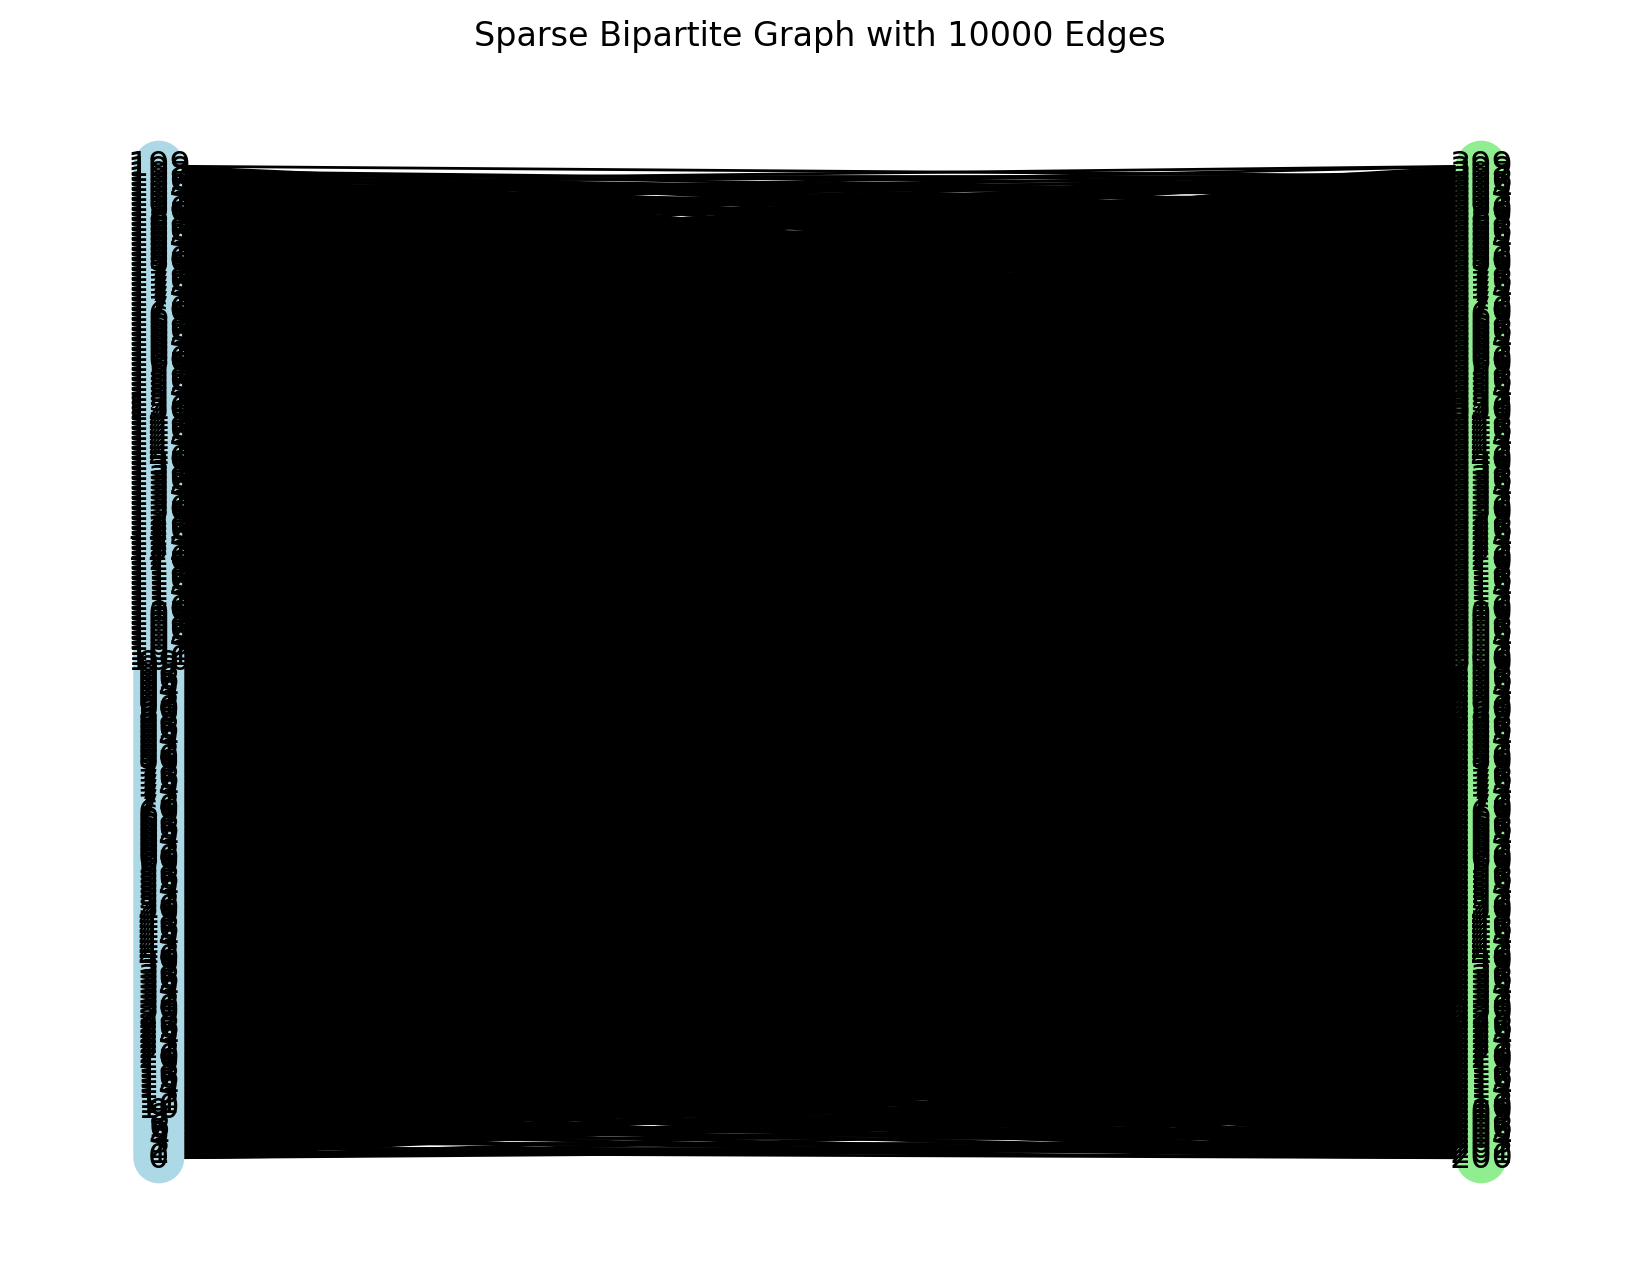

In [8]:
def create_sparse_connected_bipartite(n: int, target_edges: int):
    """
    Generates a sparse, connected, random bipartite graph of size n x n.

    This function implements a "build-up" method:
    1. It starts with two partitions of n nodes each (2n nodes total).
    2. It adds random bipartite edges until the graph is connected.
    3. It continues adding random bipartite edges until target_edges is reached.

    Args:
        n: The number of nodes in each of the two partitions.
        target_edges: The total number of edges the final graph should have.

    Returns:
        A networkx Graph object.

    Raises:
        ValueError: If the target_edges is not possible.
            - If target_edges is less than the minimum (2n - 1) required
              for a 2n-node graph to be connected.
            - If n is 0 or negative.
    """
    if n <= 0:
        raise ValueError("n must be a positive integer.")

    # --- 1. Validation ---
    min_edges = 2 * n - 1  # Minimum edges for a connected graph (spanning tree)
    max_edges = n * n      # Maximum edges in a complete K_n,n graph

    if target_edges < min_edges:
        raise ValueError(
            f"Target edges ({target_edges}) is less than the minimum ({min_edges}) "
            f"required for a connected graph of {2*n} nodes."
        )

    if target_edges > max_edges:
        print(
            f"Warning: Target edges ({target_edges}) exceeds the maximum possible "
            f"({max_edges}). Returning a complete bipartite K_{n},{n} graph."
        )
        target_edges = max_edges

    # --- 2. Initialization ---
    G = nx.Graph()
    partition_U = list(range(n))
    partition_V = list(range(n, 2 * n))
    
    # Add nodes with bipartite attribute
    G.add_nodes_from(partition_U, bipartite=0)
    G.add_nodes_from(partition_V, bipartite=1)

    # Generate all possible bipartite edges
    possible_edges = [
        (u, v) for u in partition_U for v in partition_V
    ]
    random.shuffle(possible_edges)
    
    edge_iterator = iter(possible_edges)

    # --- 3. Phase 1: Ensure Connectivity (Build Spanning Tree) ---
    # We add edges until the graph has only one connected component
    while not nx.is_connected(G):
        try:
            u, v = next(edge_iterator)
            G.add_edge(u, v)
        except StopIteration:
            # This should only happen if n=1 and target_edges=1
            break 
            
    # --- 4. Phase 2: Add Remaining Edges to Reach Target ---
    num_edges_to_add = target_edges - G.number_of_edges()

    for _ in range(num_edges_to_add):
        try:
            u, v = next(edge_iterator)
            G.add_edge(u, v)
        except StopIteration:
            # This means we've added all possible n*n edges
            break
            
    return G, partition_U, partition_V

N_NODES = 200 
TARGET_EDGES = 50 * N_NODES

print(f"Generating a {N_NODES}x{N_NODES} sparse bipartite graph...")
print(f"Target edges: {TARGET_EDGES}\n")

try:
    G, U, V = create_sparse_connected_bipartite(N_NODES, TARGET_EDGES)

    print("--- Graph Generation Successful ---")
    print(f"Partition U nodes: {U}")
    print(f"Partition V nodes: {V}")
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Final edges: {G.number_of_edges()}")
    print(f"Is connected: {nx.is_connected(G)}")
    print(f"Is bipartite: {nx.is_bipartite(G)}")

    # Example of low target edge count
    print("\n--- Testing minimum connectivity ---")
    min_edges_required = 2 * N_NODES - 1
    G_min, _, _ = create_sparse_connected_bipartite(N_NODES, min_edges_required)
    print(f"Targeting minimum edges: {min_edges_required}")
    print(f"Resulting edges: {G_min.number_of_edges()}")
    print(f"Is connected: {nx.is_connected(G_min)}")

except ValueError as e:
    print(f"Error generating graph: {e}")

#plot generated graph
plt.figure(figsize=(8, 6))
pos = nx.bipartite_layout(G, U)
nx.draw(G, pos, with_labels=True, node_color=['lightblue' if n in U else 'lightgreen' for n in G.nodes()])
plt.title(f"Sparse Bipartite Graph with {G.number_of_edges()} Edges")
plt.show()


In [9]:
# --- get target (hardware) graph ---
# Option A: prototype locally with a perfect Zephyr of size m
G_target = dnx.zephyr_graph(16)   # choose m that gives enough qubits (increase m if needed)
print(f"Target zephyr_graph (m=16): {G_target.number_of_nodes()} nodes, {G_target.number_of_edges()} edges")

# Option B: (preferred if you will run on a real sampler)
# sampler = DWaveSampler()                 # uncomment if you have credentials
# G_target = sampler.to_networkx_graph()   # real hardware topology (with defects accounted for)
# print(f"Target hardware graph: {G_target.number_of_nodes()} nodes, {G_target.number_of_edges()} edges")


# --- try minorminer ---
print("\nStarting minorminer.find_embedding...")
params = dict(tries=30, timeout=60, threads=4, chainlength_patience=20, verbose=2)
embedding = minorminer.find_embedding(G, G_target, **params)

if embedding:
    chain_lengths = [len(chain) for chain in embedding.values()]
    print("\nEmbedding found!")
    print(f"  Max chain length: {max(chain_lengths)}")
    print(f"  Avg chain length: {sum(chain_lengths)/len(chain_lengths):.2f}")
else:
    print("\nNo embedding found (embedding is empty).")
    print("Try increasing K (to make the graph sparser), increasing 'tries'/'timeout', or using a larger target graph (increase 'm').")


Target zephyr_graph (m=16): 8448 nodes, 81640 edges

Starting minorminer.find_embedding...

No embedding found (embedding is empty).
Try increasing K (to make the graph sparser), increasing 'tries'/'timeout', or using a larger target graph (increase 'm').
